### Single Train/ Multiple Output BCNN 

1. BCNN -base model

In [1]:
%matplotlib inline

import theano
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
import lasagne

In [2]:

import data_utils

Train_x, Train_y, Test_x, Test_y = data_utils.load_data()


Train_x = np.asarray(Train_x)
Train_y = np.asarray(Train_y)
Test_x  = np.asarray(Test_x)
Test_y  = np.asarray(Test_y)

## Training and Testing Input

X_train_single = Train_x[200:1700]

X_test_multi = Train_x[:200]
## Training and Testing Output

from sklearn.preprocessing import MultiLabelBinarizer

y = np.load('../behav_Exp/pri_sec_emotion.npy')

from keras.utils import to_categorical

y_train = Train_y[200:1700]

mlb = MultiLabelBinarizer()
y_test = mlb.fit_transform(y)


Using TensorFlow backend.


In [6]:
## Reshape the input value

X_train = X_train_single.reshape(X_train_single.shape[0], 1, 48, 48)
X_test  = X_test_multi.reshape(X_test_multi.shape[0], 1, 48, 48)

In [44]:
# BCNN on FER2000 First Tryout
## remove dropout for its issue for shape inconsistency 
import lasagne
total_size = len(y_train)
ann_input_minibatch = pm.Minibatch(X_train, batch_size = 50)
ann_output_minibatch = pm.Minibatch(y_train, batch_size = 50)


n_hidden = 100

# Initialize random weights between each layer

init_1 = np.random.randn( 32, 1, 5, 5)
init_2 = np.random.randn(32, 32, 5, 5)
init_out = np.random.randn(9*9*32, 7)
    
with pm.Model() as neural_network:
    
    # Priors for Weight
    c_in_1 = pm.Cauchy('r_in_1',-1, 2.5)
    c_1_2 =  pm.Cauchy('r_1_2', 0, 2)
    c_2_out = pm.Cauchy('r_2_out',0,1.5)

    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1',0.3, c_in_1, 
                             shape=( 32, 1, 5, 5), 
                             testval = init_1)
    
    weights_1_2  = pm.Normal('w_1_2',0.2, c_1_2, 
                            shape =(32, 32, 5, 5),
                            testval = init_2)
     
    weights_2_out = pm.Normal('w_2_out',0.3, c_2_out, 
                            shape=(9*9*32, 7), 
                            testval = init_out)
    
    # Build neural-network using tanh activation function
    in_1 = lasagne.layers.InputLayer((None, 1, 48, 48), 
                                       input_var=ann_input_minibatch)
    
    conv_1 = lasagne.layers.Conv2DLayer(in_1, num_filters=32, filter_size=(5, 5), 
                                      W=weights_in_1, 
                                      nonlinearity=lasagne.nonlinearities.tanh)
    
    #drop_1 = lasagne.layers.DropoutLayer(conv_1, p=0.2)
    
    
    pool_1 = lasagne.layers.MaxPool2DLayer(conv_1, pool_size=(2, 2))
    
    
    conv_2 = lasagne.layers.Conv2DLayer(pool_1, num_filters=32, filter_size=(5, 5), 
                                      W=weights_1_2, 
                                      nonlinearity=lasagne.nonlinearities.tanh)
    
    #drop_2 = lasagne.layers.DropoutLayer(conv_2, p = 0.2)
    
    pool_2 = lasagne.layers.MaxPool2DLayer(conv_2, pool_size=(2, 2))
        
    act_out = lasagne.layers.DenseLayer(pool_2, 7, 
                                        W=weights_2_out,
                                        nonlinearity=lasagne.nonlinearities.softmax)
   
    # Method 1: use model.get_output(from lasagne or Theano)
    #prediction = lasagne.layers.get_output(act_out)
    
    # Method 2: add one determininstic layer right after the final dense connection layer
    prediction = pm.Deterministic('p', lasagne.layers.get_output(act_out))
    
    #p = pm.Deterministic('p', T.nnet.softmax(net_out))
    # Binary classification -> Bernoulli likelihood
    out = pm.Categorical('out', 
                       prediction,
                       observed=(ann_output_minibatch),
                        total_size = total_size)
    ### Whether or not to flatten the prediction differs between Bernoulli and Categorical Distribution 

In [45]:
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    inference = pm.ADVI()
    approx = pm.fit(n=3500, method=inference,callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])

Average Loss = inf: 100%|██████████| 3500/3500 [22:39<00:00,  2.37it/s]
Finished [100%]: Average Loss = 7.8561e+07


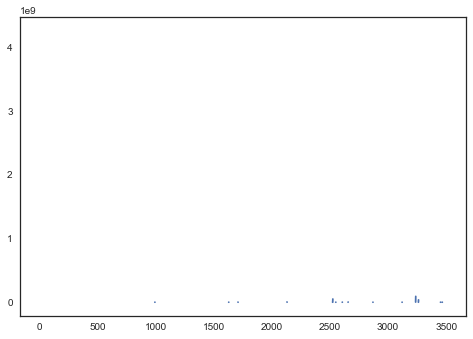

In [46]:
plt.plot(approx.hist)

In [47]:
x= T.tensor4('X')

# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
#x.tag.test_value = np.empty_like(X_train[:10])
x.tag.test_value = np.empty_like(X_train)
n.tag.test_value = 100

_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={ann_input_minibatch: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

In [48]:
pred = sample_proba(X_test, 500)

In [49]:
pred_ = pred.mean(axis = 0)

a = pred_

a[np.arange(len(a)),a.argmax(1)] = -1 

a[np.arange(len(a)),a.argmax(1)] = 1

a[np.arange(len(a)),a.argmin(1)] = 1

a[a != 1] = 0

In [50]:
from sklearn.metrics import *
print 'Hamming Loss:', hamming_loss(y_test, a)
print 'Convergence Error:', coverage_error(y_test, a)
print 'Label Ranking loss:', label_ranking_loss(y_test, a)
print 'F1-scores(Weighted)', f1_score(y_test, a, average='weighted')
print 'F1-scores(Micro)', f1_score(y_test, a, average='micro')
print 'F1-scores(Macro)', f1_score(y_test, a, average='macro')
print 'F1-scores(Samples)', f1_score(y_test, a, average='samples')
print 'Average Precision', average_precision_score(y_test,a)

Hamming Loss: 0.401428571429
Convergence Error: 6.675
Label Ranking loss: 0.7595
F1-scores(Weighted) 0.240862839718
F1-scores(Micro) 0.284987277354
F1-scores(Macro) 0.23310328587
F1-scores(Samples) 0.2825
Average Precision 0.416189208963


In [51]:
Uncert = pred.std(axis = 0)
b = Uncert

b[np.arange(len(b)), b.argmin(1)] = 2 

b[np.arange(len(b)), b.argmin(1)] = 1

b[np.arange(len(b)), b.argmax(1)] = 1

b[b != 1] = 0

In [52]:
from sklearn.metrics import *
print 'Hamming Loss:', hamming_loss(y_test, b)
print 'Convergence Error:', coverage_error(y_test, b)
print 'Label Ranking loss:', label_ranking_loss(y_test, b)
print 'F1-scores(Weighted)', f1_score(y_test, b, average='weighted')
print 'F1-scores(Micro)', f1_score(y_test, b, average='micro')
print 'F1-scores(Macro)', f1_score(y_test, b, average='macro')
print 'F1-scores(Samples)', f1_score(y_test, b, average='samples')
print 'Average Precision', average_precision_score(y_test,b)


Hamming Loss: 0.395714285714
Convergence Error: 6.8
Label Ranking loss: 0.755333333333
F1-scores(Weighted) 0.220816947075
F1-scores(Micro) 0.295165394402
F1-scores(Macro) 0.209199096897
F1-scores(Samples) 0.293333333333
Average Precision 0.389461472978


In [53]:
softmax_prob = pred.mean(axis = 0)
c = (softmax_prob / Uncert) 

In [54]:
d = c
d[np.arange(len(d)),d.argmax(1)] = -1 

d[np.arange(len(d)),d.argmax(1)] = 1

d[np.arange(len(a)),d.argmin(1)] = 1

d[d != 1] = 0

In [55]:
from sklearn.metrics import *
print 'Hamming Loss:', hamming_loss(y_test, d)
print 'Convergence Error:', coverage_error(y_test, d)
print 'Label Ranking loss:', label_ranking_loss(y_test, d)
print 'F1-scores(Weighted)', f1_score(y_test, d, average='weighted')
print 'F1-scores(Micro)', f1_score(y_test, d, average='micro')
print 'F1-scores(Macro)', f1_score(y_test, d, average='macro')
print 'F1-scores(Samples)', f1_score(y_test, d, average='samples')
print 'Average Precision', average_precision_score(y_test,d)

Hamming Loss: 0.401428571429
Convergence Error: 6.75
Label Ranking loss: 0.759
F1-scores(Weighted) 0.151181696006
F1-scores(Micro) 0.284987277354
F1-scores(Macro) 0.14006969923
F1-scores(Samples) 0.285
Average Precision 0.5758206197
